In [736]:

import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from matplotlib.animation import FuncAnimation
from IPython.display import Image, display
import ipywidgets as widgets
import datetime

In [737]:
# Parameters
sigma = 5.67E-8     # Stephan Boltzmann constant in W / m^2 / K^4
T_ground = 273.15   # temperature of the ground in K which is 0 degrees Celsius
# T_air = 273.15 - 30  # temperature of the air in K 
k = 0.2        # thermal conductivity of snow in W / m / K
c_snow = 2100       # heat capacity of snow in J /kg / K
rho_snow= 300       # density of snow in kg/m^3
S0 = 1361          # solar insolation in W m-2
alpha_snow = 0.8         # Albedo of snow
eps_snow = 0.98     # Emissivity of snow
eps_sky = 0.6       # Emissivity of the sky with a fixed value for clear sky 
thickness = 0.5     # thickness of snow in meters
Lf = 3.34E5      # latent heat of fusion in J / kg
kappa = 5.0         # attenuation coefficient for shortwave radiation in snow, m^-1
h_conv = 10.0        # convective heat transfer coefficient in W / m^2 / K

# Solar place holder 
SW_in_interp = None

# Slope Setup 
slope_deg = 10 # slope of the terrain in degrees
aspect_deg = 90 # aspect of the terrain in degrees
latitude_deg = 39.6 # latitude in degrees
longitude_deg = -105.9 # longitude in degrees

# Set up the snowpack 
# N = 100 # number of layers
N_top = 30 # top layers smaller
dz_top = 0.01 # 1cm thickness for top layers
N_bottom = 35 # bottom layers thicker
dz_bottom = 0.02 # 2cm thickness for bottom layers
H_top = N_top * dz_top
H_bottom = N_bottom * dz_bottom
H = H_top + H_bottom
# H = 1  # total thickness of snowpack in meters

z_faces_bottom = np.linspace(0, H_bottom, N_bottom+1) # z_faces_bottom[0] = 0 (bottom), z_faces_bottom[N_bottom] = H_bottom (top)
z_faces_top = np.linspace(H_bottom, H_bottom + H_top, N_top+1) # z_faces_top[0] = H_bottom (top), z_faces_top[N_top] = H (bottom)
z_F = np.concatenate((z_faces_bottom, z_faces_top[1:]))
# z_F = np.linspace(0, H, N+1) # z_F[0] = 0 (bottom), z_F[N] = H (top)
z_T = 0.5 * (z_F[:-1]+ z_F[1:]) # z_T[0] = -0.05, z_T[N-1] = -0.95
# dz = H / N # thickness of each layer in meters
N = len(z_F) - 1 # number of layers
z_T = 0.5 * (z_F[:-1] + z_F[1:]) # z_T[0] = 0.005, z_T[N-1] = 0.995
dz = z_F[1:] - z_F[:-1] # thickness of each layer in meters


# Combine them into a single array of layer faces, omitting
# the repeated boundary at H_bottom (because it appears at the end of bottom array
# and start of top array).


# Number of layers is one less than the number of faces
N = len(z_F) - 1

# Layer centers
z_T = 0.5 * (z_F[:-1] + z_F[1:])

# Thickness of each layer
dz = z_F[1:] - z_F[:-1]

print("Total thickness = ", z_F[-1])  # should be 1.0
print("z_F:\n", z_F)
print("dz:\n", dz)
print("z_T:\n", z_T)
print("Number of layers N =", N)



# Time parameters
n_days = 2 # number of days to simulate
t_end = n_days * 24 * 3600 # end time in seconds
dt_max = 100 # maximum time step in seconds
 
# Possible future parameters
wind_speed = 1.0 # wind speed in m/s
c_air = 1005 # heat capacity of air in J / kg / K
rho_air = 1.225 # density of air in kg / m^3
C_H = 0.001 # heat transfer coefficient in W / m^2 / K
SW_peak = 800 # peak solar insolation in W / m^2
penetration_depth = 0.1 # depth of solar radiation penetration in meters


# Initial conditions
# Create a temperature profile that decreases from ground temperature to surface temperature
T_snow_min = 263.15  # -3°C in Kelvin

# Initialize temperature array
T_init = np.zeros(N)

# Calculate normalized depths for each layer (0 at bottom, 1 at top)
normalized_depths = z_T/H

# Use an exponential decay profile from ground to surface
# This will give us T_ground at z=0 and approach T_snow_min at z=H
# The factor controls how quickly temperature decreases with height
decay_factor = -4.0  
temp_diff = T_ground - T_snow_min
exp_term = (1 - np.exp(-decay_factor * normalized_depths)) / (1 - np.exp(-decay_factor))
T_init = T_ground - temp_diff * exp_term

# Print temperature at a few levels to verify
print(f"Initial temperature at bottom: {T_init[0]:.2f} K ({T_init[0]-273.15:.2f}°C)")
print(f"Initial temperature at middle: {T_init[N//2]:.2f} K ({T_init[N//2]-273.15:.2f}°C)")
print(f"Initial temperature at top: {T_init[-1]:.2f} K ({T_init[-1]-273.15:.2f}°C)")




Total thickness =  1.0
z_F:
 [0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.71 0.72 0.73 0.74 0.75 0.76
 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9
 0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.  ]
dz:
 [0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
z_T:
 [0.01  0.03  0.05  0.07  0.09  0.11  0.13  0.15  0.17  0.19  0.21  0.23
 0.25  0.27  0.29  0.31  0.33  0.35  0.37  0.39  0.41  0.43  0.45  0.47
 0.49  0.51  0.53  0.55  0.57  0.59  0.61  0.63  0.65  0.67  0.69  0.705
 0.715 0.725 0.735 0.745 0.755 0.765 0.775 0.785 0.795 0.805 0.815 0.825
 0.8

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23]), array([23., 22., 21., 20., 21., 19., 19., 18., 18., 18., 20., 23., 25.,
       28., 29., 29., 29., 29., 28., 27., 25., 23., 22., 22.]), array([-1., -2., -2., -2., -5., -5., -5., -5., -6., -8., -8., -7., -7.,
       -7., -7., -6., -3., -2., -1., -1., -2.,  0.,  1.,  1.]), array([34., 34., 36., 38., 32., 34., 34., 35., 35., 31., 28., 26., 24.,
       22., 21., 22., 24., 26., 29., 31., 31., 35., 40., 40.]), array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  12., 196., 409.,
       591., 729., 812., 835., 792., 687., 525., 320., 112.,   2.,   0.,
         0.,   0.]))


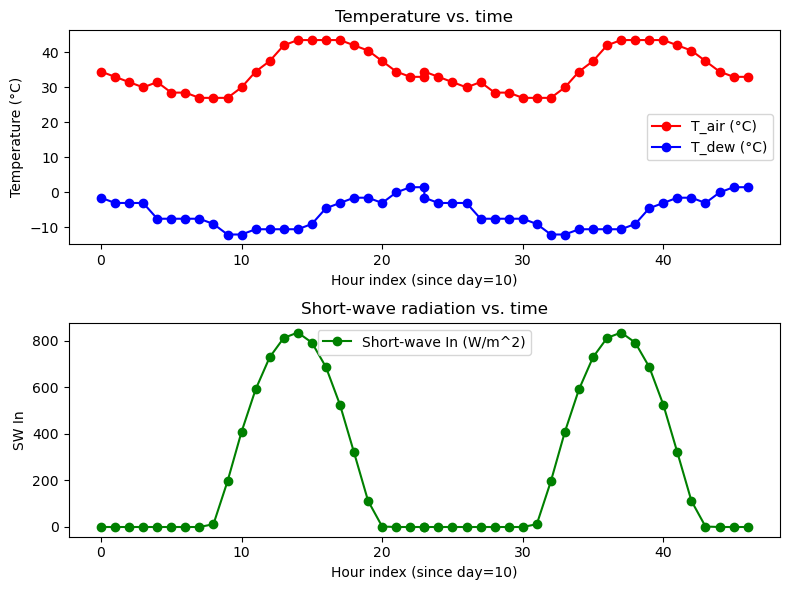

In [738]:
# read in 24 hours of station data
def read_met_data(filename):
    times = []
    T_air_list = []
    T_dwpt_list = []
    RH_list = []
    wind_speed_list = []
    sw_in_list = []
    
    with open(filename, 'r') as f:
        for line in f:
            if line.strip() == '':
                continue
            parts = line.split()
            
            day_int = int(parts[2])
            hour_part = parts[3]
            hour_str = hour_part.split(':')[0]
            hour_int = int(hour_str)
            hours_since_start = (day_int - 10) * 24 + hour_int
            
            T_air_val = float(parts[4])
            T_dwpt_val = float(parts[7])
            RH_val = float(parts[8])
            sol_val = float(parts[12])
            
            times.append(hours_since_start)
            T_air_list.append(T_air_val)
            T_dwpt_list.append(T_dwpt_val)
            RH_list.append(RH_val)
            sw_in_list.append(sol_val)
            
    times_arr = np.array(times)
    T_air_arr = np.array(T_air_list)
    T_dwpt_arr = np.array(T_dwpt_list)
    RH_arr = np.array(RH_list)
    sw_in_arr = np.array(sw_in_list)
    
    sort_idx = np.argsort(times_arr)
    times_arr = times_arr[sort_idx]
    T_air_arr = T_air_arr[sort_idx]
    T_dwpt_arr = T_dwpt_arr[sort_idx]
    RH_arr = RH_arr[sort_idx]
    sw_in_arr = sw_in_arr[sort_idx]
    
    return times_arr, T_air_arr, T_dwpt_arr, RH_arr, sw_in_arr
            
print(read_met_data('station.txt'))

filename = "station.txt"
times_1day, T_air_1day, T_dew_1day, RH_1day, SW_in_1day = read_met_data(filename)

# 5) Duplicate the 1-day data to get 2 days
#    We'll assume times_1day[0] = 0 (or near 0) and times_1day[-1] = 24 hours
#    If your data is not exactly 24 hours, adapt accordingly.

original_duration = times_1day[-1] - times_1day[0]  # e.g. ~24 hours
times_2nd_day = times_1day + original_duration      # shift everything by +24

times_extended = np.concatenate( (times_1day, times_2nd_day) )
T_air_extended = np.concatenate( (T_air_1day, T_air_1day) )
T_dew_extended = np.concatenate( (T_dew_1day, T_dew_1day) )
RH_extended    = np.concatenate( (RH_1day, RH_1day) )
SW_in_extended = np.concatenate( (SW_in_1day, SW_in_1day) )

# 6) Create Interpolation Functions Over 2 Days
#    Convert hours to seconds
times_sec = times_extended * 3600

# Scaling of temps 
cold_scale = 1.5         # set <1.0 to make colder, or >1.0 to make warmer
temp_offset = 0        # you could also add or subtract an offset in °C

T_air_extended = (T_air_extended * cold_scale) + temp_offset
T_dew_extended = (T_dew_extended * cold_scale) + temp_offset

T_air_interp_raw = interp1d(times_sec, T_air_extended,
                           kind='linear', fill_value='extrapolate')
SW_in_raw = interp1d(times_sec, SW_in_extended,
                    kind='linear', fill_value='extrapolate')

T_air_interp = interp1d(times_sec, T_air_extended, 
                        kind='linear', fill_value='extrapolate')
T_dew_interp = interp1d(times_sec, T_dew_extended, 
                        kind='linear', fill_value='extrapolate')
RH_interp    = interp1d(times_sec, RH_extended,    
                        kind='linear', fill_value='extrapolate')
SW_in_interp = interp1d(times_sec, SW_in_extended, 
                        kind='linear', fill_value='extrapolate')
plt.figure(figsize=(8,6))

plt.subplot(2,1,1)
plt.plot(times_extended, T_air_extended, 'r-o', label='T_air (°C)')
plt.plot(times_extended, T_dew_extended, 'b-o', label='T_dew (°C)')
plt.xlabel('Hour index (since day=10)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature vs. time')
plt.legend()

plt.subplot(2,1,2)
plt.plot(times_extended, SW_in_extended, 'g-o', label='Short-wave In (W/m^2)')
plt.xlabel('Hour index (since day=10)')
plt.ylabel('SW In')
plt.title('Short-wave radiation vs. time')
plt.legend()

plt.tight_layout()
plt.show()

            

In [739]:
def measured_air_temp(t_sec):
    T_C = (T_air_interp_raw(t_sec) - 32.0) * (5.0/9.0)
    return T_C + 273.15

def measured_solar_flux_horizontal(t_sec):
    return SW_in_raw(t_sec)


In [740]:
def approximate_solar_position(timestamp, lat_deg, lon_deg):
    """
    Returns (zenith_deg, azimuth_deg) for the sun at 'timestamp' (naive approach).
    lat_deg, lon_deg in degrees. 
    'timestamp' is a Python datetime object.
    """
    # Day of year
    day_of_year = timestamp.timetuple().tm_yday
    hour_of_day = timestamp.hour + timestamp.minute/60 + timestamp.second/3600

    # Solar declination (Cooper's approximation)
    decl = math.radians(23.45)*math.sin(math.radians(360*(284+day_of_year)/365))

    lat = math.radians(lat_deg)
    # naive solar time
    solar_time = hour_of_day + (lon_deg*4)/60
    hour_angle_deg = 15*(solar_time - 12)
    hour_angle = math.radians(hour_angle_deg)

    # Zenith
    cos_zen = (math.sin(lat)*math.sin(decl)
               + math.cos(lat)*math.cos(decl)*math.cos(hour_angle))
    cos_zen = np.clip(cos_zen, -1.0, 1.0)
    zen_deg = math.degrees(math.acos(cos_zen))

    # Azimuth
    sin_az = -math.cos(decl)*math.sin(hour_angle) / \
              max(math.sqrt(1 - cos_zen**2),1e-9)
    sin_az = np.clip(sin_az, -1, 1)
    cos_az = (math.sin(decl) - math.sin(lat)*cos_zen)/ \
             (math.cos(lat)*max(math.sqrt(1 - cos_zen**2),1e-9))
    az_rad = math.atan2(sin_az, cos_az)
    az_deg = math.degrees(az_rad) % 360
    return zen_deg, az_deg

def measured_solar_flux_slope(t_sec):
    """
    Slope-corrected flux. We first call the raw horizontal flux,
    then apply geometry for slope/aspect.
    """
    sw_horizontal = measured_solar_flux_horizontal(t_sec)
    if sw_horizontal <= 0:
        return 0.0

    # Convert t_sec to a naive datetime
    base_datetime = datetime.datetime(2023, 3, 10)
    current_time = base_datetime + datetime.timedelta(seconds=float(t_sec))

    zen_deg, az_deg = approximate_solar_position(current_time, latitude_deg, longitude_deg)
    if zen_deg >= 90.0:
        # sun below horizon
        return 0.0

    zen_rad = math.radians(zen_deg)
    slope_rad  = math.radians(slope_deg)
    aspect_rad = math.radians(aspect_deg)

    # slope normal
    nx = math.sin(slope_rad)*math.cos(aspect_rad)
    ny = math.sin(slope_rad)*math.sin(aspect_rad)
    nz = math.cos(slope_rad)

    # sun direction
    sx = math.sin(zen_rad)*math.sin(math.radians(az_deg))
    sy = math.sin(zen_rad)*math.cos(math.radians(az_deg))
    sz = math.cos(zen_rad)

    dot_ns = nx*sx + ny*sy + nz*sz
    if dot_ns <= 0:
        return 0.0

    cos_zen = math.cos(zen_rad)
    direct_ratio = dot_ns/(cos_zen+1e-9)
    sw_slope = sw_horizontal*direct_ratio
    return max(sw_slope, 0.0)


In [741]:
def surface_nonSW_flux(t_sec, T_surface):
    T_air = measured_air_temp(t_sec)
    LW_down = eps_sky * sigma * T_air**4
    LW_up   = eps_snow * sigma * T_surface**4
    net_lw  = LW_down - LW_up
    QH = h_conv *(T_air - T_surface)
    return net_lw + QH

def shortwave_absorption_profile(t_sec, z_faces):
    SW_in_top = (1.0 - alpha_snow)* measured_solar_flux_slope(t_sec)
    SW_abs = np.zeros(N)
    for i in range(N):
        z_low  = z_faces[i]
        z_high = z_faces[i+1] 
        flux_in  = SW_in_top * np.exp(-kappa * z_low)
        flux_out = SW_in_top * np.exp(-kappa * z_high)
        SW_abs[i] = flux_in - flux_out
    return SW_abs

In [742]:

    
""" def surface_flux(t, T_surface):
    T_air_current = measured_air_temp(t)
    sw_in = measured_solar_flux(t)
    net_sw = (1.0 - alpha_snow) * sw_in
    LW_down = eps_sky * sigma * (T_air_current**4)
    LW_up = eps_snow * sigma * (T_surface**4)
    net_lw = LW_down - LW_up
    h = 10.0  # W/m^2/K
    QH = h * (T_air_current - T_surface)
    # Could add latent heat flux here later
    return net_sw + net_lw + QH """
    

def dT_dt(t, T):
    F = np.zeros(N+1) # heat fluxes between layers
    F[0] = k * (T_ground - T[0]) / dz[0] # heat flux at the ground
    for i in range(1, N):
        F[i] = k * (T[i-1] - T[i]) / dz[i] # heat flux between layers
    
    net_surf_flux = surface_nonSW_flux(t, T[-1]) # total heat flux at the surface
    F[N] = -net_surf_flux # flux at surface    
    # net_surface_in = surface_flux(t, T[-1]) # total heat flux at the surface
    # F[N] = -net_surface_in # flux at surface
    
    dTdt = np.zeros(N) # rate of temperature change in each layer
    for i in range(N):
        dTdt[i] = -(F[i+1] - F[i]) / (rho_snow * c_snow * dz[i])
        
    SW_profile = shortwave_absorption_profile(t, z_F) # absorbed shortwave radiation in each layer
    for i in range(N):
        dTdt[i] += SW_profile[i] / (rho_snow * c_snow) # add absorbed shortwave to the rate of temperature change
    
    
    T_top = T[-1] # temperature of the top layer
    if T_top >= 273.15:
        mass_top = rho_snow * dz # mass of the top layer
        energy_rate = dTdt[-1] * mass_top * c_snow # energy rate of the top layer
        if T_top > 273.15:
            overshoot_dT = T_top - 273.15
            overshoot_energy = overshoot_dT * mass_top * c_snow # energy required to melt the top layer
            T[-1] = 273.15 # set the top layer to 0 degrees Celsius
        else:
            overshoot_energy = 0
            
        dTdt[-1] = 0.0
        
    return dTdt


In [743]:


sol = solve_ivp(
    fun=dT_dt,
    t_span=(0, t_end),
    y0=T_init,
    method='RK45',
    max_step=dt_max
)

# sol.t is the array of time points
# sol.y is an array of shape (N, len(sol.t)) where sol.y[:, i] is the temperature of each layer at time sol.t[i]
time = sol.t
T_layers = sol.y

print("Number of time steps =", len(time))



Number of time steps = 1731


In [744]:
def debug_surface_flux(t, T_surface):
    # optional function if you want to see net flux at the surface
    net_sw = (1.0 - alpha_snow)* measured_solar_flux(t)
    lw_down = eps_sky * sigma * measured_air_temp(t)**4
    lw_up   = eps_snow * sigma * T_surface**4
    net_lw = lw_down - lw_up
    QH = h_conv*(measured_air_temp(t) - T_surface)
    return net_sw + net_lw + QH

num_debug = 5
debug_indices = np.linspace(0, len(time)-1, num_debug, dtype=int)

for idx in debug_indices:
    t_now = time[idx]
    T_now = T_layers[:, idx]
    surf_flux = debug_surface_flux(t_now, T_now[-1])
    print(f"\nTime = {t_now/3600:.2f} hr")
    print(f" Bottom T = {T_now[0]:.2f} K | Top T = {T_now[-1]:.2f} K ")
    print(f" Net surface flux = {surf_flux:.2f} W/m^2")


Time = 0.00 hr
 Bottom T = 273.14 K | Top T = 263.35 K 
 Net surface flux = 37.86 W/m^2

Time = 11.95 hr
 Bottom T = 273.12 K | Top T = 266.72 K 
 Net surface flux = 152.71 W/m^2

Time = 23.98 hr
 Bottom T = 273.13 K | Top T = 265.83 K 
 Net surface flux = -7.48 W/m^2

Time = 35.98 hr
 Bottom T = 273.11 K | Top T = 268.58 K 
 Net surface flux = 176.16 W/m^2

Time = 48.00 hr
 Bottom T = 273.11 K | Top T = 265.65 K 
 Net surface flux = -5.28 W/m^2


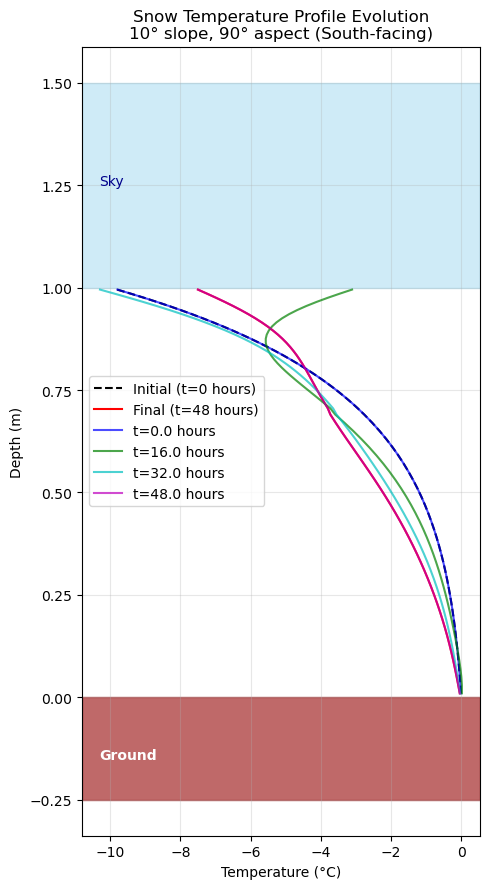

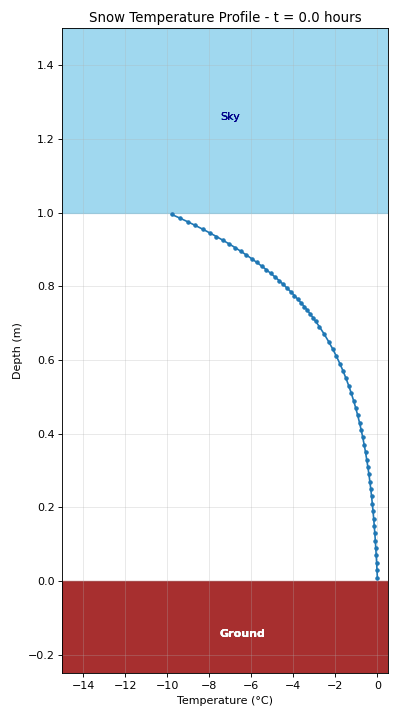

In [745]:
# Final temperature profile vs depth
final_temp = T_layers[:, -1]

plt.figure(figsize=(5,9))

# Plot initial and final profiles
plt.plot(T_init - 273.15, z_T, 'k--', label="Initial (t=0 hours)")
plt.plot(final_temp - 273.15, z_T, 'r-', label="Final (t=48 hours)")

# Add some snapshots at intermediate times
# Select a few evenly spaced snapshots
num_snapshots = 4
snapshot_indices = np.linspace(1, len(time)-2, num_snapshots, dtype=int)
colors = ['b', 'g', 'c', 'm']

for i, idx in enumerate(snapshot_indices):
    t_hours = time[idx]/3600
    snapshot_temp = T_layers[:, idx] - 273.15  # Convert to °C
    plt.plot(snapshot_temp, z_T, color=colors[i], linestyle='-', 
             alpha=0.7, label=f"t={t_hours:.1f} hours")

# Add ground and sky regions that span the full width
plt.axhspan(-0.25, 0, color='brown', alpha=0.7)  # Ground region
plt.axhspan(1, 1.5, color='skyblue', alpha=0.4)  # Sky region

# Get current x limits to position the labels
x_min, x_max = plt.xlim()  

# Add text labels for ground and sky
plt.text(x_min + 0.5, -0.15, "Ground", color='white', fontweight='bold')
plt.text(x_min + 0.5, 1.25, "Sky", color='darkblue')
plt.ylabel("Depth (m)")
plt.xlabel("Temperature (°C)")
plt.title(f"Snow Temperature Profile Evolution\n{slope_deg}° slope, {aspect_deg}° aspect")
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Video of the change over time with ground and sky layers
fig, ax = plt.subplots(figsize=(5, 9))
line, = ax.plot([], [], '-o', markersize=3)

def init():
    ax.set_xlim(-15, 0.5)  
    ax.set_ylim(-0.25, 1.5)    
    ax.set_ylabel("Depth (m)")
    ax.set_xlabel("Temperature (°C)")
    ax.set_title("Snow Temperature Profile Evolution")
    ax.grid(True, alpha=0.3)
    
    # Add ground and sky regions that span the full width
    ax.axhspan(-0.25, 0, color='brown', alpha=0.7)  # Ground region
    ax.axhspan(1, 1.5, color='skyblue', alpha=0.4)  # Sky region
    
    # Add text labels for ground and sky
    ax.text(-7.5, -0.15, "Ground", color='white', fontweight='bold')
    ax.text(-7.5, 1.25, "Sky", color='darkblue')
    
    return line,

def animate(i):
    # Select fewer points for smoother animation
    idx = int(i * len(time) / 100) if i < 100 else len(time) - 1
    t_hours = time[idx]/3600
    temp = T_layers[:, idx] - 273.15  # Convert to °C
    ax.set_title(f"Snow Temperature Profile - t = {t_hours:.1f} hours")
    line.set_data(temp, z_T)
    
    return line,

ani = FuncAnimation(fig, animate, frames=100, init_func=init, interval=100, blit=True)
plt.tight_layout()

# Save as GIF with reduced number of frames for better performance
ani.save('temperature_profile_evolution.gif', writer='pillow', fps=10, dpi=80)
plt.close()

# Display the animation
display(Image('temperature_profile_evolution.gif'))
